<a href="https://colab.research.google.com/github/sholtodouglas/learning_from_play/blob/master/notebooks/train_lfp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install wandb -q
!pip install pathy -q
!pip install comet_ml -q

     |████████████████████████████████| 2.0MB 7.0MB/s 
     |████████████████████████████████| 163kB 22.6MB/s 
     |████████████████████████████████| 102kB 9.0MB/s 
     |████████████████████████████████| 133kB 24.3MB/s 
     |████████████████████████████████| 71kB 7.7MB/s 
     |████████████████████████████████| 122kB 9.5MB/s 
     |████████████████████████████████| 256kB 6.6MB/s 
     |████████████████████████████████| 61kB 5.8MB/s 
     |████████████████████████████████| 512kB 8.9MB/s 
     |████████████████████████████████| 204kB 13.6MB/s 


In [2]:
# import comet_ml at the top of your file
from comet_ml import Experiment
import wandb
wandb.login()


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [12]:
import argparse

parser = argparse.ArgumentParser(description='LFP training arguments')
parser.add_argument('run_name')
parser.add_argument('--train_datasets', nargs='+', help='Training dataset names')
parser.add_argument('--test_datasets', nargs='+', help='Testing dataset names')
parser.add_argument('-c', '--colab', default=False, action='store_true', help='Enable if using colab environment')
parser.add_argument('-s', '--data_source', default='DRIVE', help='Source of training data')
parser.add_argument('-tfr', '--from_tfrecords', default=False, action='store_true', help='Enable if using tfrecords format')
parser.add_argument('-d', '--device', default='TPU', help='Hardware device to train on')
parser.add_argument('-b', '--batch_size', default=512, type=int)
parser.add_argument('-wmax', '--window_size_max', default=50, type=int)
parser.add_argument('-wmin', '--window_size_min', default=20, type=int)
parser.add_argument('-la', '--actor_layer_size', default=2048, type=int, help='Layer size of actor, increases size of neural net')
parser.add_argument('-le', '--encoder_layer_size', default=512, type=int, help='Layer size of encoder, increases size of neural net')
parser.add_argument('-lp', '--planner_layer_size', default=512, type=int, help='Layer size of planner, increases size of neural net')
parser.add_argument('-embd', '--img_embedding_size', default=64, type=int, help='Embedding size of features,goal space')
parser.add_argument('-z', '--latent_dim', default=256, type=int, help='Size of the VAE latent space')
parser.add_argument('-g', '--gcbc', default=False, action='store_true', help='Enables GCBC, a simpler model with no encoder/planner')
parser.add_argument('-n', '--num_distribs', default=None, type=int, help='Number of distributions to use in logistic mixture model')
parser.add_argument('-q', '--qbits', default=None, type=int, help='Number of quantisation bits to discrete distributions into. Total quantisations = 2**qbits')
parser.add_argument('-lr', '--learning_rate', type=float, default=3e-4)
parser.add_argument('-t', '--train_steps', type=int, default=200000)
parser.add_argument('-r', '--resume', default=False, action='store_true')
parser.add_argument('-B', '--beta', type=float, default=0.00003)
parser.add_argument('-i', '--images', default=False, action='store_true')
parser.add_argument('--fp16', default=False, action='store_true')
parser.add_argument('--bucket_name', help='GCS bucket name to stream data from')
parser.add_argument('--tpu_name', help='GCP TPU name') # Only used in the script on GCP


### Sample local config
args = parser.parse_args('''
dummy_run 
--train_dataset UR5
--test_dataset UR5
-tfr
'''.split())

# ## Sample colab config
# args = parser.parse_args('''
# refactor_test
# --train_dataset UR5 UR5_slow_gripper UR5_high_transition
# --test_dataset UR5_slow_gripper_test
# -c
# -tfr
# -s GCS
# -d TPU
# -b 512
# -la 2048
# -le 512
# -lp 512
# -z 256
# -lr 3e-4
# --bucket_name iowa_bucket_lfp
# -i
# '''.split())

## Sample colab config
args = parser.parse_args('''
QuantB0_01
--train_dataset UR5 UR5_slow_gripper UR5_high_transition
--test_dataset UR5_slow_gripper_test
-c
-s DRIVE
-d TPU
-b 512
-la 2048
-le 512
-lp 512
-z 256
-lr 3e-4
-B 0.01
-n 5
-q 8
'''.split())

print(args)

Namespace(actor_layer_size=2048, batch_size=512, beta=0.01, bucket_name=None, colab=True, data_source='DRIVE', device='TPU', encoder_layer_size=512, fp16=False, from_tfrecords=False, gcbc=False, images=False, img_embedding_size=64, latent_dim=256, learning_rate=0.0003, num_distribs=5, planner_layer_size=512, qbits=8, resume=False, run_name='QuantB0_01', test_datasets=['UR5_slow_gripper_test'], tpu_name=None, train_datasets=['UR5', 'UR5_slow_gripper', 'UR5_high_transition'], train_steps=200000, window_size_max=50, window_size_min=20)


## Init

In [4]:
from pathlib import Path
from pathy import Pathy
import os
import requests
import json
import pprint
import logging
import numpy as np
import tensorflow as tf
import time



pp = pprint.PrettyPrinter(indent=4)
# In[4]:


#@title Workpace Setup (Local vs Colab)

# Set up working directory and libraries
if args.colab:
    from google.colab import drive, auth
    print('Using colab setup')
    WORKING_PATH = Path('/content/learning_from_play')
    # Clone repo
    try:
        get_ipython().system("git clone 'https://github.com/sholtodouglas/learning_from_play' {WORKING_PATH}")
    except: 
        pass
    # Mount drive
    drive.mount('/content/drive')
else:
    print('Using local setup')
    WORKING_PATH = Path.cwd()
    print(f'Working path: {WORKING_PATH}')

# Change working directory to learning_from_play
os.chdir(WORKING_PATH)
import lfp

# Set up storage directory and datasets
if args.data_source == 'DRIVE':
    assert args.colab, "Must be using Colab"
    print('Reading data from Google Drive')
    STORAGE_PATH = Path('/content/drive/My Drive/Robotic Learning')
elif args.data_source == 'GCS':
    if args.colab:
      auth.authenticate_user()
    print('Reading data from Google Cloud Storage')
    r = requests.get('https://ipinfo.io')
    region = r.json()['region']
    project_id = 'learning-from-play-303306'
    logging.warning(f'You are accessing GCS data from {region}, make sure this is the same as your bucket {args.bucket_name}')
    STORAGE_PATH = Pathy(f'gs://{args.bucket_name}')
else:
    print('Reading data from local filesystem')
    STORAGE_PATH = WORKING_PATH

print(f'Storage path: {STORAGE_PATH}')
TRAIN_DATA_PATHS = [STORAGE_PATH/'data'/x for x in args.train_datasets]
TEST_DATA_PATHS = [STORAGE_PATH/'data'/x for x in args.test_datasets]

Using colab setup
Cloning into '/content/learning_from_play'...
remote: Enumerating objects: 149, done.
remote: Counting objects: 100% (149/149), done.
remote: Compressing objects: 100% (105/105), done.
remote: Total 2237 (delta 85), reused 97 (delta 44), pack-reused 2088
Receiving objects: 100% (2237/2237), 85.86 MiB | 24.51 MiB/s, done.
Resolving deltas: 100% (1322/1322), done.
Mounted at /content/drive
No pybullet installation found - which is fine if training
Reading data from Google Drive
Storage path: /content/drive/My Drive/Robotic Learning


In [5]:

print("Tensorflow version " + tf.__version__)

if args.device == "TPU":
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
        print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
    except ValueError:
        raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)

    NUM_DEVICES = strategy.num_replicas_in_sync
    
    print("REPLICAS: ", NUM_DEVICES)
else:
    physical_devices = tf.config.list_physical_devices()
    if args.device == 'GPU':
        tf.config.experimental.set_memory_growth(physical_devices[3], enable=True)
    NUM_DEVICES = 1
    print(physical_devices)

Tensorflow version 2.4.1
Running on TPU  ['10.27.68.106:8470']
INFO:tensorflow:Initializing the TPU system: grpc://10.27.68.106:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.27.68.106:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


REPLICAS:  8


In [6]:
# Use this to edit modules without needing to restart the kernel
!git pull
import importlib
importlib.reload(lfp.data)
importlib.reload(lfp.model)
importlib.reload(lfp.train)
importlib.reload(lfp.metric)

Already up to date.


<module 'lfp.metric' from '/content/learning_from_play/lfp/metric.py'>

## Data

In [8]:
GLOBAL_BATCH_SIZE = args.batch_size * NUM_DEVICES
dl = lfp.data.PlayDataloader(include_imgs = args.images, batch_size=GLOBAL_BATCH_SIZE,  window_size=args.window_size_max, min_window_size=args.window_size_min)

In [9]:
# Train data
train_data = dl.extract(TRAIN_DATA_PATHS, from_tfrecords=args.from_tfrecords)
train_dataset = dl.load(train_data)

UR5_high_transition: 100%|██████████| 32/32 [00:13<00:00,  2.44it/s]


{   'acts': TensorSpec(shape=(4096, 50, 7), dtype=tf.float32, name=None),
    'dataset_path': TensorSpec(shape=(4096, None, 1), dtype=tf.int32, name=None),
    'goals': TensorSpec(shape=(4096, 50, 11), dtype=tf.float32, name=None),
    'masks': TensorSpec(shape=(4096, 50), dtype=tf.float32, name=None),
    'obs': TensorSpec(shape=(4096, 50, 18), dtype=tf.float32, name=None),
    'seq_lens': TensorSpec(shape=(4096,), dtype=tf.float32, name=None),
    'tstep_idxs': TensorSpec(shape=(4096, None, 1), dtype=tf.int32, name=None)}


In [10]:
# Validation data
valid_data = dl.extract(TEST_DATA_PATHS, from_tfrecords=args.from_tfrecords)
valid_dataset = dl.load(valid_data)

UR5_slow_gripper_test: 100%|██████████| 2/2 [00:01<00:00,  1.90it/s]

{   'acts': TensorSpec(shape=(4096, 50, 7), dtype=tf.float32, name=None),
    'dataset_path': TensorSpec(shape=(4096, None, 1), dtype=tf.int32, name=None),
    'goals': TensorSpec(shape=(4096, 50, 11), dtype=tf.float32, name=None),
    'masks': TensorSpec(shape=(4096, 50), dtype=tf.float32, name=None),
    'obs': TensorSpec(shape=(4096, 50, 18), dtype=tf.float32, name=None),
    'seq_lens': TensorSpec(shape=(4096,), dtype=tf.float32, name=None),
    'tstep_idxs': TensorSpec(shape=(4096, None, 1), dtype=tf.int32, name=None)}


# Training Loop

In [22]:
from lfp.train import LFPTrainer

def train_setup():
    model_params = {'obs_dim':args.img_embedding_size + dl.proprioceptive_features_dim if args.images else dl.obs_dim,
                'goal_dim':args.img_embedding_size if args.images else dl.goal_dim,
                'act_dim':dl.act_dim,
                'layer_size':args.actor_layer_size, 
                'latent_dim':args.latent_dim}

    actor = lfp.model.create_actor(**model_params, gcbc=args.gcbc, num_distribs=args.num_distribs, qbits=args.qbits)

    if args.gcbc:
        encoder = None
        planner = None
    else:
        model_params['layer_size'] = args.encoder_layer_size
        encoder = lfp.model.create_encoder(**model_params)
        model_params['layer_size'] = args.planner_layer_size
        planner = lfp.model.create_planner(**model_params)

    if args.images:
      cnn = lfp.model.create_vision_network(dl.img_size, dl.img_size, embedding_size=args.img_embedding_size)
    else:
      cnn = None

    #optimizer = tfa.optimizers.LAMB(learning_rate=args.learning_rate)
    optimizer = tf.optimizers.Adam(learning_rate=args.learning_rate)
    trainer = LFPTrainer(args, actor, dl, encoder, planner, cnn, optimizer, strategy, GLOBAL_BATCH_SIZE)
    return actor, encoder, planner, trainer


if args.device=='CPU' or args.device=='GPU':
     actor, encoder, planner, trainer = train_setup()
else:
    with strategy.scope():
         actor, encoder, planner, trainer = train_setup()
        
        
train_dist_dataset = iter(strategy.experimental_distribute_dataset(train_dataset))
valid_dist_dataset = iter(strategy.experimental_distribute_dataset(valid_dataset))
plotting_dataset = iter(valid_dataset) #for the cluster fig, easier with a non distributed dataset


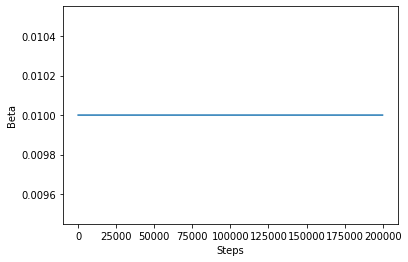

In [23]:
from lfp.train import BetaScheduler


# 0.00001 so far works best for MAE - try lower - 0.00003 with a BETA accel of 10 so far works best, perfect encoder, nicely mapped planner
# recall 0.01 worked okay for probabilistic - proba still too unstable!
beta_sched = BetaScheduler('linear', 
                           beta=args.beta, 
                           beta_max=args.beta, 
                           max_steps=args.train_steps, 
                           cycles=90, 
                           duty_cycle=0.5
                           )

In [24]:

from tensorflow.keras.utils import Progbar
progbar = Progbar(args.train_steps, verbose=1, interval=0.5)
valid_inc = 20
save_inc = 2000
prev_grad_norm = np.float('inf')

In [25]:
run_name = args.run_name
model_path = str(STORAGE_PATH/'saved_models'/args.run_name)

if args.resume:
  # WandB reinit
  with open(f'{model_path}/config.json', 'r') as f:
      data = json.load(f)
  # Comet ML reinit
  exp = ExistingExperiment(api_key="C4vcCM57bnSYEsdncguxDW8pO",  previous_experiment=data['experiment_key'])

  wandb.init(project="learning-from-play_v2", id=data['run_id'],  resume="must")
  t = wandb.run.step + valid_inc # Todo get this from comet to complete the transition

  load_weights(model_path, actor, encoder, planner, with_optimizer=True)
  print('Loaded model weights and optimiser state')
  
  prognar.add(t, []) # update the progbar to the most recent point
else:
  #Comet
  experiment = Experiment(api_key="C4vcCM57bnSYEsdncguxDW8pO",project_name="learning-from-play",workspace="sholtodouglas")
  experiment.set_name(run_name)
  # WandB
  wandb.init(project="learning-from-play_v2")
  wandb.run.name = run_name
  t = 0


COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/sholtodouglas/learning-from-play/e42b7dd59c2d43da9e139a57f3f2e1a9
COMET INFO:   Others:
COMET INFO:     Name : QuantB0_01
COMET INFO:   Parameters:
COMET INFO:     Adam_amsgrad       : 1
COMET INFO:     Adam_beta_1        : 0.9
COMET INFO:     Adam_beta_2        : 0.999
COMET INFO:     Adam_decay         : 1
COMET INFO:     Adam_epsilon       : 1e-07
COMET INFO:     Adam_learning_rate : 0.0003
COMET INFO:     Optimizer          : Adam
COMET INFO:   Uploads:
COMET INFO:     environment details : 1
COMET INFO:     filename            : 1
COMET INFO:     git metadata        : 1
COMET INFO:     installed packages  : 1
COMET INFO:     os packages         : 1
COMET INFO: ---------------------------
COMET INFO: Experiment is live on comet.ml https://www.

In [26]:
from lfp.plotting import produce_cluster_fig, project_enc_and_plan, plot_to_image
from lfp.metric import log

In [28]:
while t < args.train_steps:
    start_time = time.time()
    beta = beta_sched.scheduler(t)
    x = next(train_dist_dataset)
    total_train_loss = trainer.distributed_train_step(x, beta)
    
    if t % valid_inc == 0:  
        valid_x = next(valid_dist_dataset)
        if args.gcbc:
          total_val_loss = trainer.distributed_test_step(valid_x, beta)
        else:
          total_val_loss = trainer.distributed_test_step(valid_x, beta)

        metrics = {metric_name: log(metric) for metric_name, metric in trainer.metrics.items()}

        # validation plotting
        progbar.add(valid_inc, [('Train Loss', metrics['train_loss']), 
                                ('Validation Loss', metrics['valid_loss']), 
                                ('Time (s)', round(time.time() - start_time, 1))])
        #Plot on Comet
        experiment.log_metrics(metrics,step=t)
        # Plot on WandB
        wandb.log(metrics, step=t)

        prev_grad_norm = metrics['global_grad_norm']
          
    if t % save_inc == 0:
        trainer.save_weights(model_path, run_id=wandb.run.id, experiment_key=experiment.get_key())
        if not args.gcbc:
          z_enc, z_plan = produce_cluster_fig(next(plotting_dataset), encoder, planner, TEST_DATA_PATHS[0], num_take=dl.batch_size//4)

          #Comet
          experiment.log_figure('z_enc', z_enc, step=t)
          experiment.log_figure('z_plan', z_plan,step=t)

          # WandB
          wandb.log({'z_enc':z_enc, 'z_plan':z_plan}, step=t)
          
          #latent_fig = project_enc_and_plan(ze, zp)
          #latent_img = plot_to_image(latent_fig)

    t += 1

    20/200000 [..............................] - ETA: 1242:46:10 - Train Loss: 0.9558 - Validation Loss: 0.8403 - Time (s): 1.2000Saving training config...


AttributeError: ignored